## Topic Modelling

In [ ]:
# Data Importing
import pandas as pd
df = pd.read_csv("/Users/valentinabrivio/Downloads/mentalhealth_with.csv")


# Data Cleaning
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()


def clean(text):
    return ' '.join([stemmer.stem(token.lemma_)
                     for token in nlp(text)
                     if (token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'}) and
                     (len(token) > 2) and  # removed words shorter than 2 characters as they created problems in topic identification
                     not token.is_stop and
                     not token.is_punct])

In [ ]:
# Preprocessing
df['title'] = df['title'].astype(str)
df['text'] = df['text'].astype(str)

In [ ]:
# Merging title and text together to create the documents
df['tot_comment'] = df['title'] + ' ' + df['text']
df['tot_comment_cleaned'] = df.tot_comment.apply(clean)

df = df[df['tot_comment_cleaned'].notnull()]

df['tot_comment_cleaned'] = df['tot_comment_cleaned'].apply(str)
len(df)

2848

In [ ]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time
import multiprocessing

instances = df['tot_comment_cleaned'].apply(str.split).tolist()

# Creating the dictionaru of our model
print("Creating dictionary")
phrases = Phrases(instances, min_count=3, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# Eliminating words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.6)
print(dictionary, flush=True)

print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

# Creating TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

coherence_values = []

# Creating the models for all topics in range 2 to 10 to select the one which maximes coherence
for num_topics in range(2, 10):
    model = LdaMulticore(corpus=model_corpus,
                         id2word=dictionary,
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model,
                                          texts=instances,
                                          dictionary=dictionary,
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model,
                                       texts=instances,
                                       dictionary=dictionary,
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()

    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))


Creating dictionary
Dictionary<261 unique tokens: ['caus', 'complet', 'cri', 'feel', 'great']...>
translating corpus to IDs
tf-idf transformation
2 -0.954311128630304 0.27532647528930365
3 -0.9888668048907139 0.2763446627677877
4 -1.0699672154283624 0.27818723321831856
5 -1.0526168866781673 0.28284897240940116
6 -1.0570788626598784 0.2784298180657285
7 -1.0535441464931583 0.2712476549845663
8 -1.0507844202928922 0.27577486237142135
9 -1.0638757180338807 0.27170056108038587


In [ ]:
# Fitting the LDA model with the established number of topics and extracting the main words of each topic

# Coherence is maximised at 5 topics
num_topics = 5
num_passes = 15 # how many times we look at the data
chunk_size = len(model_corpus) * num_passes/200 #we want to update the model every 200 instances
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1),
                     passes=num_passes,
                     chunksize=chunk_size,
                     alpha=0.5, #alpa is a hyperparameter that affects sparsity of document-topic loadings
                     random_state=42
                    )

print("done in {}".format(time.time()-start), flush=True)

topic_corpus = model[model_corpus]

import re
topic_sep = re.compile("0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + '))
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=6)]
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

213.6
fitting model
done in 28.108177185058594
1 "mental", "health", "suicid", "ill", "help"
2 "depress", "anxieti", "sleep", "therapi", "medic"
3 "work", "job", "school", "lose", "week"
4 "fuck", "look", "die", "guy", "happen"
5 "tell", "friend", "talk", "cri", "hurt"


In [ ]:
model.print_topics()

[(0,
  '0.044*"mental" + 0.036*"health" + 0.025*"suicid" + 0.023*"ill" + 0.020*"help" + 0.020*"person" + 0.020*"self" + 0.020*"issu" + 0.019*"disord" + 0.019*"peopl"'),
 (1,
  '0.037*"depress" + 0.034*"anxieti" + 0.024*"sleep" + 0.024*"therapi" + 0.022*"medic" + 0.020*"take" + 0.019*"eat" + 0.019*"therapist" + 0.018*"question" + 0.017*"med"'),
 (2,
  '0.029*"work" + 0.025*"job" + 0.021*"school" + 0.020*"lose" + 0.019*"week" + 0.019*"year" + 0.018*"day" + 0.017*"new" + 0.017*"home" + 0.016*"end"'),
 (3,
  '0.020*"fuck" + 0.019*"look" + 0.018*"die" + 0.017*"guy" + 0.017*"happen" + 0.017*"idk" + 0.016*"wrong" + 0.016*"hate" + 0.016*"world" + 0.015*"feel"'),
 (4,
  '0.025*"tell" + 0.024*"friend" + 0.022*"talk" + 0.022*"cri" + 0.021*"hurt" + 0.020*"kill" + 0.020*"say" + 0.018*"want" + 0.017*"mom" + 0.017*"scare"')]

## Topics distribution and top posts

In [ ]:
# Topic distribution
import numpy as np

doc_topic_dist = np.array([max(model[doc], key=lambda x: x[1])[0] for doc in model_corpus])
topic_coverage = [(i, np.sum(doc_topic_dist == i) / len(doc_topic_dist) * 100) for i in range(num_topics)]

for topic_num, coverage in topic_coverage:
    print(f"Topic {topic_num + 1}: {coverage:.2f}% of documents")

Topic 1: 20.15% of documents
Topic 2: 22.44% of documents
Topic 3: 19.91% of documents
Topic 4: 25.39% of documents
Topic 5: 12.11% of documents


In [ ]:
# Computing top comments for each post
import numpy as np

doc_topic_probs = [model.get_document_topics(bow) for bow in model_corpus]

sorted_docs_by_topic = [[] for _ in range(num_topics)]

for i, doc_probs in enumerate(doc_topic_probs):
    for topic_num, prob in doc_probs:
        sorted_docs_by_topic[topic_num].append((i, prob))

for topic_list in sorted_docs_by_topic:
    topic_list.sort(key=lambda x: x[1], reverse=True)

In [ ]:
top_n = 4
df_top_doc = pd.DataFrame()


# Display the top N documents for each topic
for topic_num, doc_list in enumerate(sorted_docs_by_topic):
    print(f"Topic {topic_num + 1}: Top {top_n} Documents")
    for doc_index, contribution in doc_list[:top_n]:
        print(f"Document Index: {doc_index}, Contribution: {contribution:.4f}")
        print(f"Document Text: {df.iloc[doc_index]['tot_comment']}")
    print("\n")

Topic 1: Top 4 Documents
Document Index: 2657, Contribution: 0.6206
Document Text: Self diagnosis help My husband (m37) self diagnosed himself with ADHD and depression. I (f36) do believe his behaviour is of someone with mental health challenges. I’ve asked him to seek proper diagnosis as that is the only way to deal should it be the case. I no longer know how to calm him or communicate with him without it being made into conflict as he’s diagnosed me with narcissism when I call him out for issues or anything. His family doesn’t help the situation as they seek to make me a bad person and enable some of the choices he makes. 

Help what is the best way forward?

Document Index: 2659, Contribution: 0.5986
Document Text: Treatment - Australia I have had a very negative experience with mental health professionals diagnosing me with an illness i do not have and very aggressive treatment from mental health proffessionals. Wondering if there are others out there having the same issue? 


Docu

In [ ]:
# Creating dataframes to store the top comments
df_top_doc_0 = pd.DataFrame()
top_docs_0 = sorted_docs_by_topic[0][:top_n]
df_top_doc_0['topic 0 comment'] = [df.tot_comment.iloc[i] for i, _ in top_docs_0]
df_top_doc_0['contributions'] = [contribution for _, contribution in top_docs_0]

df_top_doc_1 = pd.DataFrame()
top_docs_1 = sorted_docs_by_topic[1][:top_n]
df_top_doc_1['topic 1 comment'] = [df.tot_comment.iloc[i] for i, _ in top_docs_1]
df_top_doc_1['contributions'] = [contribution for _, contribution in top_docs_1]

df_top_doc_2 = pd.DataFrame()
top_docs_2 = sorted_docs_by_topic[2][:top_n]
df_top_doc_2['topic 2 comment'] = [df.tot_comment.iloc[i] for i, _ in top_docs_2]
df_top_doc_2['contributions'] = [contribution for _, contribution in top_docs_2]

df_top_doc_3 = pd.DataFrame()
top_docs_3 = sorted_docs_by_topic[3][:top_n]
df_top_doc_3['topic 3 comment'] = [df.tot_comment.iloc[i] for i, _ in top_docs_3]
df_top_doc_3['contributions'] = [contribution for _, contribution in top_docs_3]

df_top_doc_4 = pd.DataFrame()
top_docs_4 = sorted_docs_by_topic[4][:top_n]
df_top_doc_4['topic 4 comment'] = [df.tot_comment.iloc[i] for i, _ in top_docs_4]
df_top_doc_4['contributions'] = [contribution for _, contribution in top_docs_4]

df_top_doc_0.to_csv('top_0.csv')
df_top_doc_1.to_csv('top_1.csv')
df_top_doc_2.to_csv('top_2.csv')
df_top_doc_3.to_csv('top_3.csv')
df_top_doc_4.to_csv('top_4.csv')


## Visualizing the topics

In [ ]:
pip install gensim pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Preparing the visualization data
vis_data = gensimvis.prepare(model, model_corpus, dictionary)

# Displaying the interactive visualization in a Jupyter Notebook
pyLDAvis.display(vis_data)

# To save the visualization to an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

In [ ]:
import numpy as np

# Get the topic distribution for each document in the corpus
topic_distributions = [model.get_document_topics(bow) for bow in model_corpus]

# Initialize an empty array to hold all topic contributions
topic_contributions = np.zeros((len(topic_distributions), model.num_topics))

# Populate the array with the topic contributions
for i, doc_topics in enumerate(topic_distributions):
    for topic, prob in doc_topics:
        topic_contributions[i, topic] = prob

# Calculate the mean topic contribution per topic across all documents
mean_topic_contributions = topic_contributions.mean(axis=0)

# Print out the mean contribution for each topic
for topic_num, mean_contrib in enumerate(mean_topic_contributions):
    print(f"Topic {topic_num + 1}: {mean_contrib:.2%}")

Topic 1: 19.37%
Topic 2: 19.68%
Topic 3: 21.38%
Topic 4: 19.84%
Topic 5: 19.73%


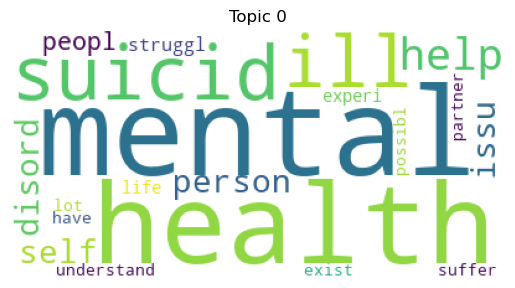

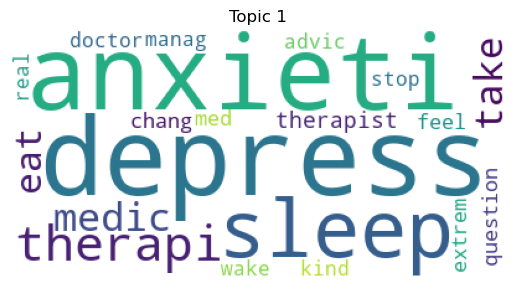

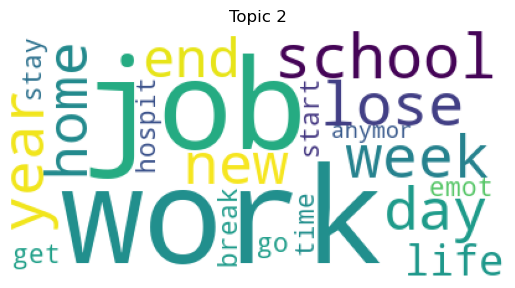

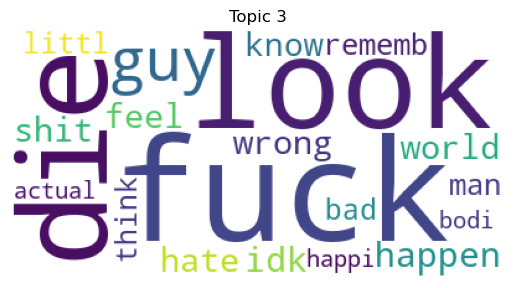

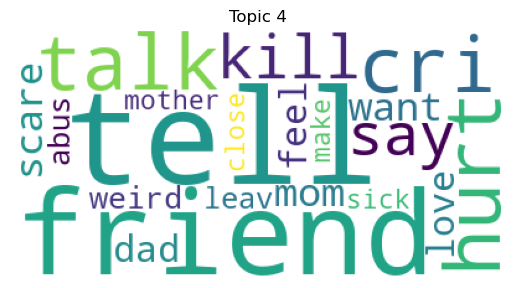

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for t in range(model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').generate_from_frequencies(dict(model.show_topic(t, 20))))
    plt.title(f'Topic {t}')
    plt.axis("off")
    plt.show()


The wordcloud representation helps us in further identifying a comprehensive title for the topics discussed:

0. Mental health management: The main topic of discussion here is mental health toghether with its complications.
1. Depression and anxiety : here the main topic of discussion is mental disorders, the issues connected to it, and the solutions. With words like "depression," "anxiety," "mental," "health," "help," "therapy", and "sleep".  
2. Stress in daily life: Here, the conversation seems to pivot around the spheres of work and education. "Job," "work," and "school" are straightforward, while "lose," "year," "week," "day," "new," "home," and "life" reflect the transitions, the flow of time, and the challenges of balancing different aspects of daily life and long-term aspirations.
3. Anger and expletives: here the topics seems to revolve around the issues of anger, frustration, and overall strong negative feelings.
4. Expressing feelings and thoughts: exploring the issues of communicating struggles and feelings with others. Talking about them and wanting to be heard.

## Checking for stability of the model

In [ ]:
import pandas as pd
import time
import re
from gensim.models import LdaMulticore
import multiprocessing
num_topics = 5
# find chunksize to make about 200 updates
num_passes = 15 # how many times we look at the data
chunk_size = len(model_corpus) * num_passes/200 #we want to update the model every 200 instances
print(chunk_size)

# Fixing the DataFrame columns: We will create columns for each model and for formatted words
columns = ['Topic'] + [f'Model {i}' for i in range(1, 51)] + [f'Formatted Words {i}' for i in range(1, 51)]
df_topics = pd.DataFrame(columns=columns)

# Shortened random_list for the 10 models we are creating
#create a random list of 50 random seeds
random_list = [42, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
for i in range(1, 51):
    random_seed = random_list[i - 1]
    start = time.time()
    print(f"fitting model {i}", flush=True)
    model = LdaMulticore(
        num_topics=num_topics,
        corpus=model_corpus,
        id2word=dictionary,
        workers=min(10, multiprocessing.cpu_count() - 1),
        passes=num_passes,
        chunksize=chunk_size,
        alpha=0.5,
        random_state=random_seed
    )
    print("done in {:.2f} seconds".format(time.time() - start), flush=True)

    # Transform the data into topic distributions
    topic_corpus = model[model_corpus]

    # Extract topic descriptions only once
    topic_sep = re.compile("0\.[0-9]{3}\*")  # getting rid of useless formatting
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + '))
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=10)]

    # Store topics and formatted words in DataFrame correctly
    for topic_no, words in model_topics:
        formatted_words = ", ".join(words).replace('"', '')
        df_topics.loc[topic_no, 'Topic'] = topic_no + 1  # Topics are numbered starting from 1
        df_topics.loc[topic_no, f'Model {i}'] = formatted_words # Storing formatted words directly

# Drop unused 'Formatted Words' columns as they are redundant
df_topics = df_topics.drop(columns=[f'Formatted Words {i}' for i in range(1, 51)])

213.6
fitting model 1
done in 26.42 seconds
fitting model 2
done in 16.84 seconds
fitting model 3
done in 15.70 seconds
fitting model 4
done in 15.46 seconds
fitting model 5
done in 15.52 seconds
fitting model 6
done in 15.37 seconds
fitting model 7
done in 15.56 seconds
fitting model 8
done in 15.25 seconds
fitting model 9
done in 15.97 seconds
fitting model 10
done in 15.52 seconds
fitting model 11
done in 15.21 seconds
fitting model 12
done in 15.14 seconds
fitting model 13
done in 15.09 seconds
fitting model 14
done in 15.03 seconds
fitting model 15
done in 14.94 seconds
fitting model 16
done in 14.56 seconds
fitting model 17
done in 14.95 seconds
fitting model 18
done in 14.63 seconds
fitting model 19
done in 14.29 seconds
fitting model 20
done in 14.58 seconds
fitting model 21
done in 14.54 seconds
fitting model 22
done in 14.59 seconds
fitting model 23
done in 14.19 seconds
fitting model 24
done in 14.26 seconds
fitting model 25
done in 14.51 seconds
fitting model 26
done in 14.

In [ ]:
import pandas as pd
import time
import re
from gensim.models import LdaMulticore
import multiprocessing
num_topics = 5
# find chunksize to make about 200 updates
num_passes = 15 # how many times we look at the data
chunk_size = len(model_corpus) * num_passes/200 #we want to update the model every 200 instances
print(chunk_size)

# Fixing the DataFrame columns: We will create columns for each model and for formatted words
columns = ['Topic'] + [f'Model {i}' for i in range(1, 101)] + [f'Formatted Words {i}' for i in range(1, 101)]
df_topics = pd.DataFrame(columns=columns)

# Shortened random_list for the 10 models we are creating
#create a random list of 100 random seeds
random_list = [42, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

for i in range(1, 101):
    random_seed = random_list[i - 1]
    start = time.time()
    print(f"fitting model {i}", flush=True)
    model = LdaMulticore(
        num_topics=num_topics,
        corpus=model_corpus,
        id2word=dictionary,
        workers=min(10, multiprocessing.cpu_count() - 1),
        passes=num_passes,
        chunksize=chunk_size,
        alpha=0.5,
        random_state=random_seed
    )
    print("done in {:.2f} seconds".format(time.time() - start), flush=True)

    # Transform the data into topic distributions
    topic_corpus = model[model_corpus]

    # Extract topic descriptions only once
    topic_sep = re.compile("0\.[0-9]{3}\*")  # getting rid of useless formatting
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + '))
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=10)]

    # Store topics and formatted words in DataFrame correctly
    for topic_no, words in model_topics:
        formatted_words = ", ".join(words).replace('"', '')
        df_topics.loc[topic_no, 'Topic'] = topic_no + 1  # Topics are numbered starting from 1
        df_topics.loc[topic_no, f'Model {i}'] = formatted_words # Storing formatted words directly

# Drop unused 'Formatted Words' columns as they are redundant
df_topics = df_topics.drop(columns=[f'Formatted Words {i}' for i in range(1, 101)])

213.6
fitting model 1


done in 19.79 seconds
fitting model 2
done in 14.72 seconds
fitting model 3
done in 15.48 seconds
fitting model 4
done in 15.58 seconds
fitting model 5
done in 15.69 seconds
fitting model 6
done in 15.94 seconds
fitting model 7
done in 16.48 seconds
fitting model 8
done in 16.72 seconds
fitting model 9
done in 16.90 seconds
fitting model 10
done in 16.23 seconds
fitting model 11
done in 16.70 seconds
fitting model 12
done in 16.80 seconds
fitting model 13
done in 16.07 seconds
fitting model 14
done in 16.87 seconds
fitting model 15
done in 16.13 seconds
fitting model 16
done in 16.41 seconds
fitting model 17
done in 16.74 seconds
fitting model 18
done in 16.30 seconds
fitting model 19
done in 16.01 seconds
fitting model 20
done in 15.93 seconds
fitting model 21
done in 16.15 seconds
fitting model 22
done in 16.13 seconds
fitting model 23
done in 15.90 seconds
fitting model 24
done in 15.55 seconds
fitting model 25
done in 15.99 seconds
fitting model 26
done in 15.69 seconds
fitting mod

## DOC2VEC stability check

In [ ]:
topics_titles = ["Mental health: requesting help in issues related to mental health disorders, illnesses and struggles. mental, health, suicid, ill, help, issu, person, disord, self, struggl",
                "Depression and anxiety: discussing problems, solutions such as medications, therapy and various questions. depress, anxieti, sleep, therapi, medic, therapist, take, eat, chang, question",
                "Stress in daily life: Here, the conversation seems to pivot around the spheres of work and education, and its impact on interpersonal relationships. work, job, school, lose, year, week, day, home, new, life ",
                "Anger and expletives: exploring expressions of anger, frustration, and overall strong negative feelings, such as hate and tiredness. fuck, look, die, guy, happen, idk, world, wrong, feel, shit",
                "Expressing feelings and thoughts: communicating and talking with friends, family, and overall discussing interpersonal relationships. tell, friend, hurt, cri, talk, say, kill, mom, scare, want "]

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming df_topics contains different topic descriptions from 50 different models

# Tag documents for Doc2Vec
def tag_documents(texts, tag_prefix):
    return [TaggedDocument(words=text.split(), tags=[f'{tag_prefix}_{i}']) for i, text in enumerate(texts)]

# Train a Doc2Vec model on the first set of topics
#model1_tagged = tag_documents(df_topics['Model 1'].tolist(), 'model1')
model1_tagged = tag_documents(topics_titles, 'topics_titles')
doc2vec_model1 = Doc2Vec(model1_tagged, vector_size=500, window=10, min_count=1, workers=10)
doc2vec_model1.train(model1_tagged, total_examples=doc2vec_model1.corpus_count, epochs=35)

# Initialize a list to store similarity results
model_similarities = []

for i in range(2, 51):
    # Tag documents for each subsequent model's topics
    model_tagged = tag_documents(df_topics[f'Model {i}'].tolist(), f'model{i}')

    # Infer vectors for the new set of topics using the trained model
    model1_vectors = [doc2vec_model1.infer_vector(doc.words) for doc in model1_tagged]
    model_vectors = [doc2vec_model1.infer_vector(doc.words) for doc in model_tagged]

    # Calculate cosine similarities between the two sets of inferred vectors
    similarities = cosine_similarity(np.array(model1_vectors), np.array(model_vectors))

    threshold = 0.7 # Define a similarity threshold
    labels = []

    for sim in similarities:
        max_similarity = np.max(sim)
        # Find the maximum similarity in each row
        if max_similarity > threshold:
            labels.append(str(int(np.argmax(sim) + 1)))
        else:
            labels.append(np.nan)

    # Store the similarity results for this pair of models
    model_similarities.append(labels)

# You can then analyze the model_similarities list to assess topic stability across models


In [ ]:
#turn model_similarities into a df
df_model_similarities = pd.DataFrame(model_similarities)
df_model_similarities = df_model_similarities.T
df_model_similarities
#count how many times the label '1' appears in the whole dataframe in the columns
perc_1 = df_model_similarities.apply(pd.Series.value_counts).loc['1'].sum()/50
perc_2 = df_model_similarities.apply(pd.Series.value_counts).loc['2'].sum()/50
perc_3 = df_model_similarities.apply(pd.Series.value_counts).loc['3'].sum()/50
perc_4 = df_model_similarities.apply(pd.Series.value_counts).loc['4'].sum()/50
perc_5 = df_model_similarities.apply(pd.Series.value_counts).loc['5'].sum()/50
print(perc_1, perc_2, perc_3, perc_4, perc_5)

0.62 0.78 0.5 0.6 0.48


Considering our data source, namely social media, and its quality, we can be satisfied of the stability of our topic model. Moroever, by visual inspection it also appears clear that the topics analyzed and the keywords reappearing in the topics are consistent across the different models. It is also important to note that two different topics overlap and therefore may cause potential confusion in the labeling of the 50 models' results.

## Correlation of word distribution stability check

In [ ]:
import pandas as pd
import time
import re
from gensim.models import LdaMulticore
import multiprocessing

models = []

# Shortened random_list for the 10 models we are creating
#create a random list of 50 random seeds
random_list = [42, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
               19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
               37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
for i in range(1, 51):
    random_seed = random_list[i - 1]
    start = time.time()
    print(f"fitting model {i}", flush=True)
    model = LdaMulticore(
        num_topics=num_topics,
        corpus=model_corpus,
        id2word=dictionary,
        workers=min(10, multiprocessing.cpu_count() - 1),
        passes=num_passes,
        chunksize=chunk_size,
        alpha=0.5,
        random_state=random_seed
    )
    print("done in {:.2f} seconds".format(time.time() - start), flush=True)

    models.append(model)

In [ ]:
def get_topic_word_distribution(model, num_topics):
    topic_word_distribution = []
    for t_id in range(num_topics):
        topic_terms = model.get_topic_terms(t_id, topn=len(dictionary))
        # Create a list of frequencies, index aligned with the dictionary
        freq_list = [0] * len(dictionary)
        for term_id, weight in topic_terms:
            freq_list[term_id] = weight
        topic_word_distribution.append(freq_list)
    return np.array(topic_word_distribution)

base_model_dist = get_topic_word_distribution(models[0], num_topics=5)

In [ ]:
for model in models[1:]:
    compare_model_dist = get_topic_word_distribution(model, num_topics=5)
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(base_model_dist, compare_model_dist)[:5, 5:]
    print("Correlation between corresponding topics of two models:")
    #print(correlation_matrix)
    #print only the max value for each column of the correlation matrix and make it red if it is above 50%
    for i in range(5):
        max_corr = max(correlation_matrix[i])
        print(f"Topic {i+1}: {max_corr:.2f}")


Correlation between corresponding topics of two models:
Topic 1: 0.49
Topic 2: 0.53
Topic 3: 0.57
Topic 4: 0.36
Topic 5: 0.48
Correlation between corresponding topics of two models:
Topic 1: 0.56
Topic 2: 0.44
Topic 3: 0.57
Topic 4: 0.38
Topic 5: 0.46
Correlation between corresponding topics of two models:
Topic 1: 0.57
Topic 2: 0.42
Topic 3: 0.50
Topic 4: 0.50
Topic 5: 0.33
Correlation between corresponding topics of two models:
Topic 1: 0.56
Topic 2: 0.53
Topic 3: 0.53
Topic 4: 0.39
Topic 5: 0.43
Correlation between corresponding topics of two models:
Topic 1: 0.33
Topic 2: 0.52
Topic 3: 0.34
Topic 4: 0.44
Topic 5: 0.34
Correlation between corresponding topics of two models:
Topic 1: 0.43
Topic 2: 0.37
Topic 3: 0.36
Topic 4: 0.24
Topic 5: 0.49
Correlation between corresponding topics of two models:
Topic 1: 0.40
Topic 2: 0.39
Topic 3: 0.35
Topic 4: 0.33
Topic 5: 0.29
Correlation between corresponding topics of two models:
Topic 1: 0.37
Topic 2: 0.51
Topic 3: 0.63
Topic 4: 0.53
Topic 

By analyzing the distribution of the words it is possible to note that most of the models showcase correlation higher than 50% for at least 2 of the 5 topics analyzed, showing that the distribution of the words remains correlated.